## Eljo Kondi Winter 2023

Worked with: Benjamin Hinshaw, Crawford Hovis

## Final Project COSC 74

In [386]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Perceptron, SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MaxAbsScaler, normalize, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.compose import ColumnTransformer
from scipy import sparse
import joblib

import warnings
warnings.filterwarnings("ignore")

import sklearn.metrics as metrics

In [387]:
train_data = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
labels = train_data["overall"]
text = train_data[["reviewText", 'summary']]
text.summary = text.summary.fillna('0')
test.summary = test.summary.fillna('0')
test_data = test[["reviewText", 'summary']]

train_input, test_input, train_labels, test_labels = train_test_split(text, labels, test_size=0.2)

### Binary Classification

In [400]:
# changes the values in accordance to the cutoff
def apply_cutoff(predicted, cutoff):
    applied = []

    for i in range(len(predicted)):
        if predicted[i] > cutoff:
            applied.append(1)
        else:
            applied.append(0)

    return applied

class BinaryClassifier():
    def __init__(self, train_data, train_labels, model='logreg'):
        
        # using different vectorizers for review and summary
        count_vector = CountVectorizer(stop_words='english', binary=True)
        tfidf_vector = TfidfVectorizer(stop_words='english', binary=True)
        
        # preprocess data
        self.preproc = ColumnTransformer([('reviews', count_vector, 'reviewText'),
                                          ('summaries', tfidf_vector, 'summary')], remainder='passthrough')
        
        transformed_data = self.preproc.fit_transform(train_data, train_labels)

        self.modelType = model
    
        # apply appropriate model
        if model == 'logreg':
            param_grid = {'penalty': ['l1', 'l2'], 
                          'C': [0.1, 1, 10], 
                          'solver': ['liblinear'],
                          'max_iter': [1000],
                          'class_weight': ['balanced']}
            
            self.model = GridSearchCV(LogisticRegression(), param_grid=param_grid, error_score='raise', scoring='f1')
            
            # fit to normalized data
            self.model.fit(normalize(transformed_data, norm='l2'), train_labels)
            
        elif model == 'SGD':
            param_grid = {'class_weight': ['balanced'], 
                          'alpha':[0.01, 0.1], 
                          'max_iter': [100]}
            
            self.model = GridSearchCV(SGDClassifier(), param_grid=param_grid, scoring='f1')
            
            # fit to normalized data
            self.model.fit(normalize(transformed_data, norm='l2'), train_labels)
            
        elif model == 'perceptron':
            param_grid = {'penalty': ['l1', 'l2'],
                          'alpha': [0.001, 0.01],
                          'tol': [1e-4, 1e-5],
                          'max_iter': [1000]}
            
            self.model = GridSearchCV(Perceptron(), param_grid=param_grid, error_score='raise', scoring='f1')
            
            # fit to data
            self.model.fit(transformed_data, train_labels)
        
        else:
            print("Not a valid model!\n")

    def predict(self, test_input):
        return self.model.predict(self.preproc.transform(test_input))
    
    def evaluate(self, predicted, actual, cutoff):
        # report confusion matrix
        confusion = metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted)
        plt.title("Confusion Matrix")
        plt.show()
        
        # calculate auc, f1, accuracy, precision, and recall
        auc = metrics.roc_auc_score(actual, predicted)
        macrof1 = metrics.f1_score(actual, predicted)
        accuracy = metrics.accuracy_score(actual, predicted)
        precision = metrics.precision_score(actual, predicted)
        recall = metrics.recall_score(actual, predicted)

        # calculate fpr tpr and thresholds
        fpr, tpr, thresholds = metrics.roc_curve(actual, predicted)

        # plot fpr and tpr
        plt.plot(fpr, tpr)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show()

        # report metrics
        print("Cutoff:", cutoff, "\nAccuracy:", accuracy, "\nPrecision:", accuracy, "\nRecall:", accuracy, "\nAUC score:", auc, "\nF1 score:", macrof1, "\nFPR:", fpr, "\nTPR", tpr)

        print("Thresholds:\n", thresholds)

### Binary Classification Testing

#### Logistic Regression

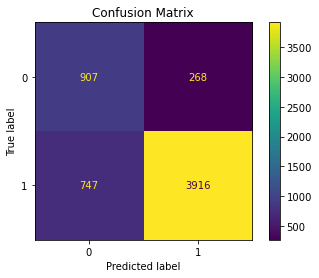

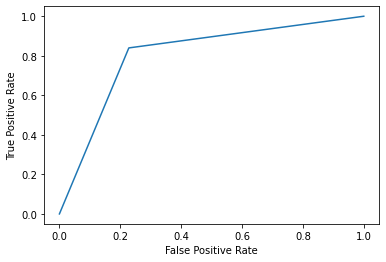

Cutoff: 1 
Accuracy: 0.8261390887290168 
Precision: 0.8261390887290168 
Recall: 0.8261390887290168 
AUC score: 0.805858797870059 
F1 score: 0.8852718435627895 
FPR: [0.         0.22808511 1.        ] 
TPR [0.        0.8398027 1.       ]
Thresholds:
 [2 1 0]


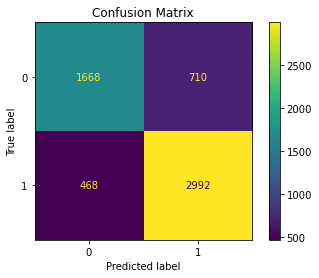

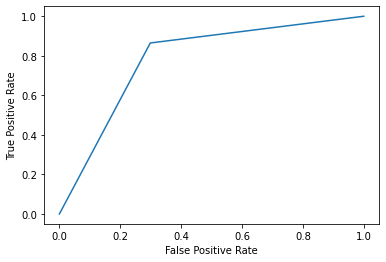

Cutoff: 2 
Accuracy: 0.7982185680027407 
Precision: 0.7982185680027407 
Recall: 0.7982185680027407 
AUC score: 0.7830848286557412 
F1 score: 0.8355208042446244 
FPR: [0.         0.29857023 1.        ] 
TPR [0.         0.86473988 1.        ]
Thresholds:
 [2 1 0]


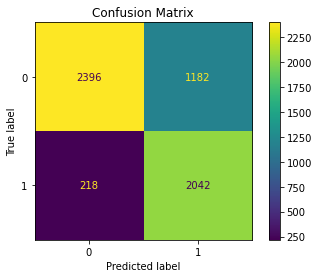

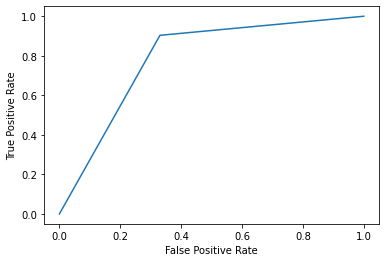

Cutoff: 3 
Accuracy: 0.7601918465227818 
Precision: 0.7601918465227818 
Recall: 0.7601918465227818 
AUC score: 0.7865938354843018 
F1 score: 0.7447118891320205 
FPR: [0.         0.33035215 1.        ] 
TPR [0.         0.90353982 1.        ]
Thresholds:
 [2 1 0]


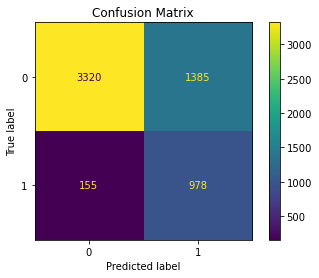

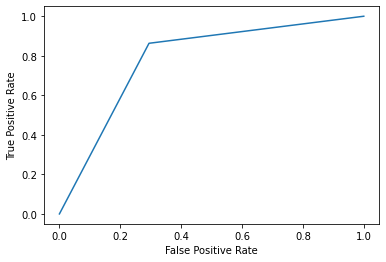

Cutoff: 4 
Accuracy: 0.7362110311750599 
Precision: 0.7362110311750599 
Recall: 0.7362110311750599 
AUC score: 0.7844136817136002 
F1 score: 0.5594965675057209 
FPR: [0.         0.29436769 1.        ] 
TPR [0.         0.86319506 1.        ]
Thresholds:
 [2 1 0]


In [392]:
for i in range(1, 5):
    binary_train_labels = []
    binary_test_labels = []
    
    
    for j in range(len(test_labels)):
        if test_labels.iloc[j] > i:
            binary_test_labels.append(1)
        else:
            binary_test_labels.append(0)
            
    for j in range(len(train_labels)):
        if train_labels.iloc[j] > i:
            binary_train_labels.append(1)
        else:
            binary_train_labels.append(0)
            
    binclass = BinaryClassifier(train_input, binary_train_labels)
    
    predicted = binclass.predict(test_input)

    binclass.evaluate(predicted, binary_test_labels, i)
    

#### SGD

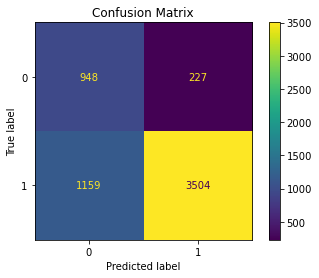

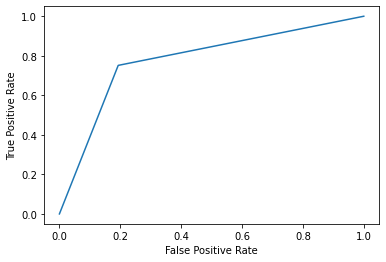

Cutoff: 1 
Accuracy: 0.762589928057554 
Precision: 0.762589928057554 
Recall: 0.762589928057554 
AUC score: 0.7791280382914844 
F1 score: 0.8348820586132952 
FPR: [0.         0.19319149 1.        ] 
TPR [0.         0.75144757 1.        ]
Thresholds:
 [2 1 0]


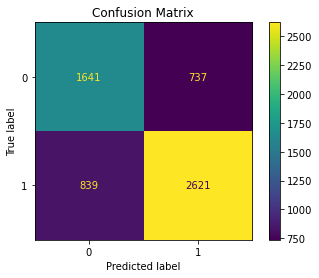

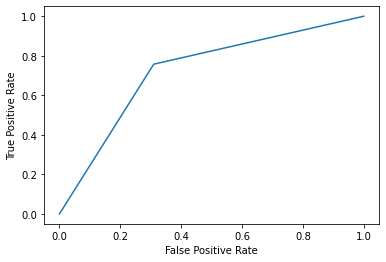

Cutoff: 2 
Accuracy: 0.7300445357999314 
Precision: 0.7300445357999314 
Recall: 0.7300445357999314 
AUC score: 0.7237950723637196 
F1 score: 0.7688471692578469 
FPR: [0.         0.30992431 1.        ] 
TPR [0.         0.75751445 1.        ]
Thresholds:
 [2 1 0]


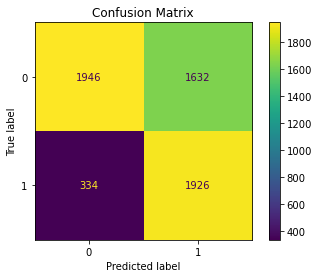

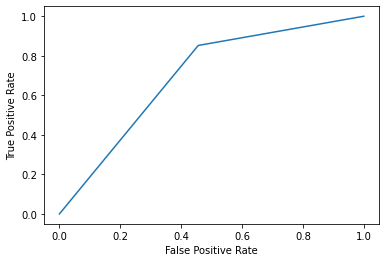

Cutoff: 3 
Accuracy: 0.6632408359027064 
Precision: 0.6632408359027064 
Recall: 0.6632408359027064 
AUC score: 0.6980458257690806 
F1 score: 0.6620831900996906 
FPR: [0.         0.45612074 1.        ] 
TPR [0.         0.85221239 1.        ]
Thresholds:
 [2 1 0]


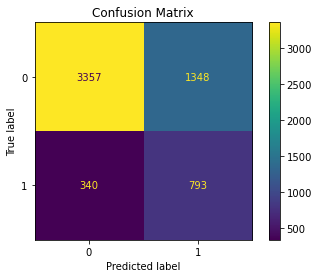

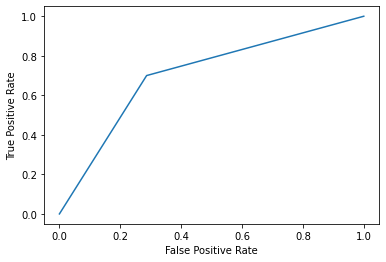

Cutoff: 4 
Accuracy: 0.710859883521754 
Precision: 0.710859883521754 
Recall: 0.710859883521754 
AUC score: 0.706704009649647 
F1 score: 0.48442272449602936 
FPR: [0.         0.28650372 1.        ] 
TPR [0.         0.69991174 1.        ]
Thresholds:
 [2 1 0]


In [401]:
for i in range(1, 5):
    binary_train_labels = []
    binary_test_labels = []
    
    for j in range(len(test_labels)):
        if test_labels.iloc[j] > i:
            binary_test_labels.append(1)
        else:
            binary_test_labels.append(0)
            
    for j in range(len(train_labels)):
        if train_labels.iloc[j] > i:
            binary_train_labels.append(1)
        else:
            binary_train_labels.append(0)
            
    binclass = BinaryClassifier(train_input, binary_train_labels, model='SGD')
    
    predicted = binclass.predict(test_input)

    binclass.evaluate(predicted, binary_test_labels, i)

#### Perceptron

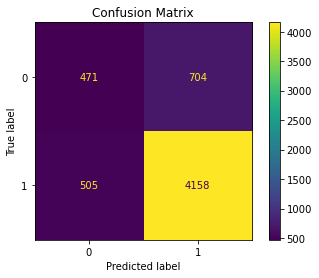

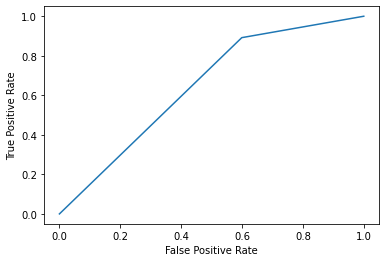

Cutoff: 1 
Accuracy: 0.7929085303186023 
Precision: 0.7929085303186023 
Recall: 0.7929085303186023 
AUC score: 0.6462758428735038 
F1 score: 0.8730708661417322 
FPR: [0.         0.59914894 1.        ] 
TPR [0.         0.89170062 1.        ]
Thresholds:
 [2 1 0]


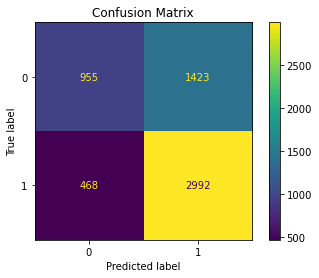

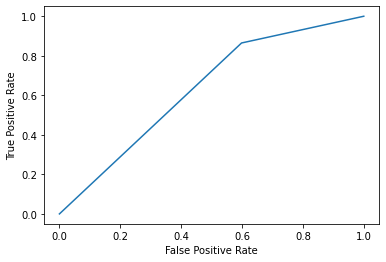

Cutoff: 2 
Accuracy: 0.6760877012675574 
Precision: 0.6760877012675574 
Recall: 0.6760877012675574 
AUC score: 0.63316893294506 
F1 score: 0.7598730158730158 
FPR: [0.         0.59840202 1.        ] 
TPR [0.         0.86473988 1.        ]
Thresholds:
 [2 1 0]


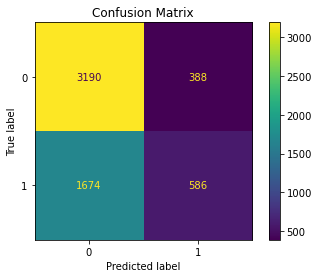

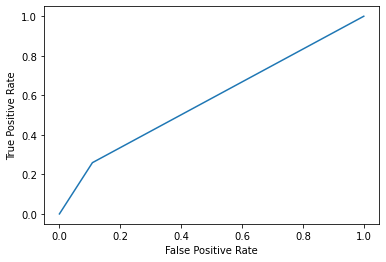

Cutoff: 3 
Accuracy: 0.6467968482356972 
Precision: 0.6467968482356972 
Recall: 0.6467968482356972 
AUC score: 0.5754257829310881 
F1 score: 0.3623995052566481 
FPR: [0.         0.10844047 1.        ] 
TPR [0.         0.25929204 1.        ]
Thresholds:
 [2 1 0]


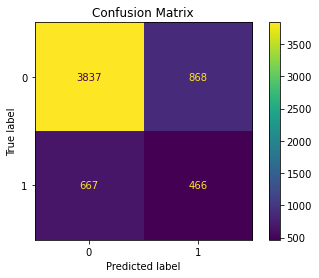

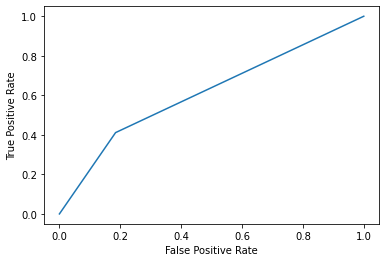

Cutoff: 4 
Accuracy: 0.73706748886605 
Precision: 0.73706748886605 
Recall: 0.73706748886605 
AUC score: 0.6134064247814338 
F1 score: 0.37778678556951767 
FPR: [0.         0.18448459 1.        ] 
TPR [0.         0.41129744 1.        ]
Thresholds:
 [2 1 0]


In [402]:
for i in range(1, 5):
    binary_train_labels = []
    binary_test_labels = []
    
    
    for j in range(len(test_labels)):
        if test_labels.iloc[j] > i:
            binary_test_labels.append(1)
        else:
            binary_test_labels.append(0)
            
    for j in range(len(train_labels)):
        if train_labels.iloc[j] > i:
            binary_train_labels.append(1)
        else:
            binary_train_labels.append(0)
            
    binclass = BinaryClassifier(train_input, binary_train_labels, model='perceptron')
    
    predicted = binclass.predict(test_input)

    binclass.evaluate(predicted, binary_test_labels, i)

#### Kaggle Test

In [ ]:
# for i in range(1, 5):
#     binary_train_labels = []
            
#     for j in range(len(train_data)):
#         if train_data.overall[j] > i:
#             binary_train_labels.append(1)
#         else:
#             binary_train_labels.append(0)
            
#     binclass = BinaryClassifier(text, binary_train_labels)
    
#     test_ids = list(test.index)
#     test_predicted = binclass.predict(test)
    
#     test_submission = pd.DataFrame({'id':test_ids, 'predicted':test_predicted})
#     print(test_submission.shape)
    
#     if i == 1:
#         test_submission.to_csv('test_submissionc_part_1.csv', index=False)
#     elif i == 2:
#         test_submission.to_csv('test_submissionc_part_2.csv', index=False)
#     elif i == 3:
#         test_submission.to_csv('test_submissionc_part_3.csv', index=False)
#     elif i == 4:
#         test_submission.to_csv('test_submissionc_part_4.csv', index=False)

### Multiclass Classification

In [413]:
class MulticlassClassifier():
    def __init__(self, train_data, train_labels, model='logreg'):
        # two different vectorizers for reviews and summaries
        count_vector = CountVectorizer(stop_words='english', binary=True)
        tfidf_vector = TfidfVectorizer(stop_words='english', binary=True)
        
        self.preproc = ColumnTransformer([('reviews', count_vector, 'reviewText'),
                                          ('summaries', tfidf_vector, 'summary')], remainder='passthrough')
        
        transformed_data = self.preproc.fit_transform(train_data, train_labels)
        
        # decide model type
        if model == 'logreg':
            param_grid = {'penalty': ['l2'], 
                      'C': [0.1, 1], 
                      'solver': ['lbfgs'],
                      'max_iter': [120]}
            
            self.model = GridSearchCV(LogisticRegression(), param_grid=param_grid)
            
            self.model.fit(normalize(transformed_data, norm='l2'), train_labels)
        elif model == 'svc':
            param_grid = {'gamma': [0.01, 0.1],
                          'kernel': ['linear', 'poly'],
                          'max_iter': [100], 
                          'probability': [True]}
            
            self.model = OneVsRestClassifier(GridSearchCV(SVC(), param_grid=param_grid, error_score='raise', scoring='f1'))
            
            self.model.fit(transformed_data, train_labels)
            
        elif model == 'sgd':
            param_grid =  {'class_weight': ['balanced'], 
                           'loss':['modified_huber'], 
                           'alpha':[0.001, 0.01, 0.1]}
            
            self.model = OneVsRestClassifier(GridSearchCV(SGDClassifier(), param_grid=param_grid, scoring = 'f1_macro'))
            
            self.model.fit(transformed_data, train_labels)

        else:
            print("Not a valid model!\n")

    def predict(self, test_input):
        return self.model.predict_proba(self.preproc.transform(test_input))
    
    def evaluate(self, predicted, actual):
        predicted_class = []
        
        # figure out prediction from probabilities
        for i in range(len(predicted)):
            sliced = list(predicted[i, :])
            predicted_class.append(sliced.index(max(sliced)) + 1)
        
        # display the confusion matrix
        metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted_class)
        plt.title("Confusion Matrix")
        plt.show()
        
        # calculate auc, f1, accuracy scores
        auc = metrics.roc_auc_score(actual, predicted, multi_class='ovr')
        macrof1 = metrics.f1_score(actual, predicted_class, average='macro')
        accuracy = metrics.accuracy_score(actual, predicted_class)

        # report metrics
        print("Accuracy:", accuracy, "\nAUC score:", auc, "\nF1 score:", macrof1)
        

#### Logistic Regression Test

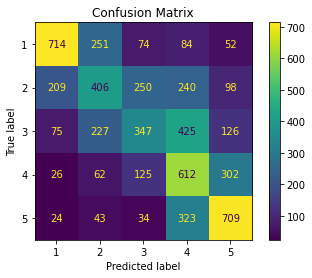

Accuracy: 0.4775608084960603 
AUC score: 0.7774606898708245 
F1 score: 0.47521353796473803


In [404]:
multiclass = MulticlassClassifier(train_input, train_labels, model='logreg')


predicted = multiclass.predict(test_input)

multiclass.evaluate(predicted, test_labels)

#### SGD Test

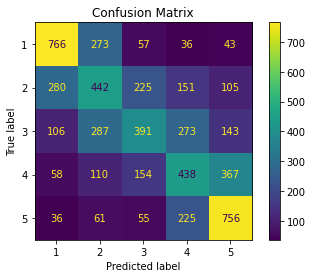

Accuracy: 0.4784172661870504 
AUC score: 0.7760001654350223 
F1 score: 0.47268470614864533


In [405]:
multiclass = MulticlassClassifier(train_input, train_labels, model='sgd')


predicted = multiclass.predict(test_input)

multiclass.evaluate(predicted, test_labels)

#### SVC Test

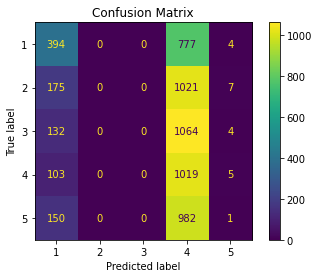

Accuracy: 0.2422062350119904 
AUC score: 0.5348723186718851 
F1 score: 0.14241872904556405


In [414]:
multiclass = MulticlassClassifier(train_input, train_labels, model='svc')


predicted = multiclass.predict(test_input)

multiclass.evaluate(predicted, test_labels)

#### Kaggle Test

In [ ]:
# multiclass = MulticlassClassifier(text, labels, model='logreg')

# test_ids = list(test.index)
# predicted = multiclass.predict(test_data)

# predicted_class = []

# # figure out prediction from probabilities
# for i in range(len(predicted)):
#     sliced = list(predicted[i, :])
#     predicted_class.append(sliced.index(max(sliced)) + 1)

# test_submission = pd.DataFrame({'id':test_ids, 'predicted':predicted_class})
# print(test_submission.shape)

# test_submission.to_csv('test_submission_multif.csv', index=False)

### Clustering

In [211]:
class Clustering():
    def __init__(self, test_input, test_labels):
        # reduce dimensions and vectorize
        pca = PCA(n_components=2, random_state=42)
        self.vectorizer = TfidfVectorizer(stop_words='english')
        
        self.input = pca.fit_transform(self.vectorizer.fit_transform(test_input).toarray())
        
        self.labels = test_labels

    def cluster(self, k):
        # run clustering
        kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=10)
        
        kmeans.fit(self.input)
        
        return kmeans
        
    
    def evaluate(self, kmeans):
        return metrics.rand_score(self.labels, kmeans.labels_), metrics.silhouette_score(self.input, kmeans.labels_, sample_size=2000)

### Clustering testing

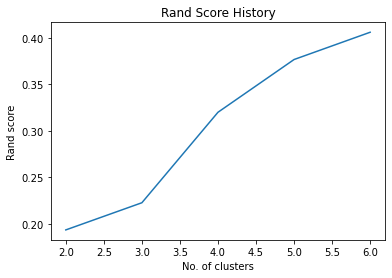

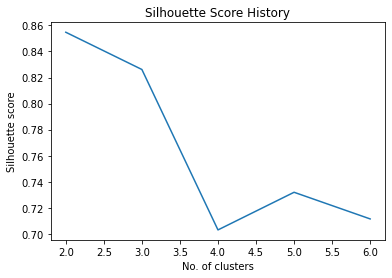

In [415]:
clusterer = Clustering(test.reviewText, test.category)

k = np.unique(test.category).shape[0]

rand_scores = []
silhoutte_scores = []
k_hist = []

# cluster up to 6
for i in range(2, k + 1):
    kmeans = clusterer.cluster(i)
    
    # store current number of clusters
    k_hist.append(i)
    
    # store the rand score and silhouette score
    rand, silhoutte = clusterer.evaluate(kmeans)
    rand_scores.append(rand)
    silhoutte_scores.append(silhoutte)

    
plt.plot(k_hist, rand_scores)
plt.title("Rand Score History")
plt.xlabel("No. of clusters")
plt.ylabel("Rand score")
plt.show()
plt.plot(k_hist, silhoutte_scores)
plt.title("Silhouette Score History")
plt.xlabel("No. of clusters")
plt.ylabel("Silhouette score")
plt.show()

### Analysis

#### Binary Classification

The different classifiers I chose for my binary classification were Logistic Regression, SGD, and Perceptron. The data columns that I used were the review text and the summary. After also trying the vote and category, I decided on using the summary in addition to the review text as it seemed to make the most difference. I used the CountVectorizer to vectorize the review text, after also comparing performance with the HashVectorizer and TfidfVectorizer, and settled on the latter for the summaries.
* Overall, the best performing model was the Logistic Regression, with f1 scores 0.88, 0.83, 0.74, and 0.55 respectively for the training data classifications. On the test dataset, this model was above the Kaggle baseline for the 1, 2, and 4 cutoffs, but fell slightly short of the cutoff 3 baseline with 0.78. The hyperparameters tuned for this model were the penalty (between lasso and ridge), the strength of the regularization, and different solvers (namely lbfgs and saga, both less efficient) and maximum iterations were tested but not included in the final output as it would take too much time to run.
* The stochastic gradient descent also had similar performance to the Logistic Regression although was overall slightly worse. The hyperparameters tuned were the alpha, and also different numbers of max iterations until settling for a middle ground.
* The worst of the three models was definitely the Perceptron model. It had significantly worse f1 scores and worse accuracy in general. Even after tuning the penalty (between l1 and l2), the alpha as well as the iterations and the stopping criterion, the model still seemed to not perform well.

All of the classifiers were tested on the training dataset and had these metrics reported above:
* Confusion Matrix
* Roc, Auc
* False positive, true positive plot
* Accuracy, precision, recall
* F1 score


#### Multiclass Classification

The different classifiers I chose for my multiclass classification were Logistic Regression, SGD, and SVC. The data columns that I used were the review text and the summary.
For the multiclass problem, I mostly utilized the 'ovr' - one versus rest strategy to pick the class.
* Once again, the best performing model was Logistic Regression, with an f1 score of 0.47 on the training data test split, and a 0.473 on the Kaggle competition, above the baseline. For the multiclass classification I settled on the lbfgs solver for Logistic Regression, with a set l2 penalty. I tried different values of the regularization strength, and settled on a maximum iteration number of 120 for good and fast classification.
* The stochastic gradient descent again had similar performance to the Logistic Regression, with an f1 score of 0.47. This time the hyperparameters tested were the alpha, as well as different loss functions, but set at a balanced class weight. 
* The worst of the three models in this case was the SVC model. The confusion matrix did not take the shape expected and the model itself seemed to not be particularly suited to this task at an f1 score of 0.14. The model was tested with both a linear and polynomial kernel, as well as at different kernel coefficients.

All of the classifiers were tested on the training dataset and had these metrics reported above:
* Confusion Matrix
* Auc
* Accuracy
* F1 score


#### Clustering

For clustering, I made use of the principal component analysis provided by sklearn in order to reduce the dimensionality of the data (which would be difficult to cluster as the sparse matrix was quite big). After calculating the maximum number of categories, I proceeded to try clustering from 2 to that number, recording the rand score history and the silhouette score history.
* The rand score continuously increased as more clusters were added. That meant that the model was able to better cluster the reviews in categories as it neared the actualamount of categories in the review pool.
* The silhouette score decreased as more clusters were added, which was natural as there is a continuously bigger chance of a point being between clusters when there are more clusters present. However, this score remained comfortably above the baseline and as such, the clusters are not overlapping too much and the model is more confident.
Plots for the rand score and silhouette score histories were provided above.

Note: Some of my Kaggle submissions were past the deadline and are likely not on the leaderboard as a result. Please let me know if I need to provide any evidence of my Kaggle scores!